# Classifying NC vs PAE - Pre-trained SFCN Model - Using Processed MRI

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nibabel as nib
from scipy.stats import norm
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, AddChanneld, RandRotated, Lambda, ToTensor

In [2]:
# Keeping all file names in the list.
NC_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\NC_Resized_MRI"
PAE_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\PAE_Resized_MRI"

in_X = []
out_y = []

for file_name in os.listdir(NC_MRI_path):
    in_X.append(NC_MRI_path + "/" + file_name)
    out_y.append(0)
    
for file_name in os.listdir(PAE_MRI_path):
    in_X.append(PAE_MRI_path + "/" + file_name)
    out_y.append(1)
    
print(len(in_X), len(out_y))

401 401


In [3]:
X = []
y = []

for i in range(0, len(in_X), +1):
    mri = nib.load(in_X[i])
    data = mri.get_fdata()
    
    # Adding an extra dimension at the begining. From (160,192,160) to (1,160,192,160).
    data = data[np.newaxis, ...]
    
    X.append(data)
    y.append(out_y[i])
    
# Converting to numpy array.   
X = np.array(X)
y = np.array(y)

print(X[0].shape)
print(y[0].shape)

(1, 160, 192, 160)
()


# Simple Fully Convolutional Network (SFCN) Architecture

In [4]:
class SFCN(nn.Module):
    def __init__(self, channel_number):  # channel_number = [28, 58, 128, 256, 256, 64]
        super(SFCN, self).__init__()
        
        n_layer = len(channel_number)
        
        self.feature_extractor = nn.Sequential()
        
        for i in range(n_layer):
            if i == 0:
                in_channel = 1
            else:
                in_channel = channel_number[i-1]
                
            out_channel = channel_number[i]
            
            if i < n_layer-1:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 1))
            else:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = False, kernel_size = 1, padding = 0))
    
    
    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 0, maxpool_stride = 2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU(),
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer
    

    def forward(self, input_image):
        extracted_features = self.feature_extractor(input_image) 
        
        return extracted_features   #shape: [64,5,6,5]
    

channel_number = [28, 58, 128, 256, 256, 64] # Sex-prediction
#channel_number = [32, 64, 128, 256, 256, 64] # Brain-Age-prediction

model = SFCN(channel_number)

# Loading pre-trained model - Removing weights and biases for Classification Part

In [5]:
tm = "BSP_run_20191008_00_epoch_last.p" # Pre-trained model aka weights and biases of already trained model for sex prediction.
#tm = "BAP_run_20190719_00_epoch_best_mae.p" # This is for Brain Age prediction.
state_dict = torch.load(tm)

for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [6]:
# Removing weight and bias (parameters) of classifier layer.
state_dict.pop('module.classifier.conv_6.weight', None)
state_dict.pop('module.classifier.conv_6.bias', None)

tensor([ 0.0604, -0.0605], device='cuda:0')

In [7]:
# Printing weights and biases parameter shape after removing classifier.
for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [8]:
# Loading after removing the classificaiton part
model.load_state_dict(state_dict, strict = False)
model

SFCN(
  (feature_extractor): Sequential(
    (conv_0): Sequential(
      (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_1): Sequential(
      (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_2): Sequential(
      (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_3): Seque

# Freezing Feature Extraction Layers of Pre-trained SFCN Model


In [9]:
for param in model.parameters():
    param.requires_grad = False

# Adding a Classification Layer on Top of SFCN Architecture

In [10]:
def create_model():
    # Number of node in the final layer
    num_classes = 1

    # Defining the modified model by adding layers
    modified_model = nn.Sequential(
        model, # pre-trained SFCN model (feature extractor) for feature extraction
        nn.Flatten(),
        nn.Linear(9600, 512),  # number of output features from the pre-trained model: 64*5*6*5 = 9600
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
        nn.Sigmoid()  # Using Sigmoid activation for binary classification
    )
    
    return modified_model

modified_model = create_model()
modified_model

Sequential(
  (0): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

# Creating Dataset, Dataloader -- 5-Fold Train-Val-Test

In [11]:
# 5-Fold cross-validation method to train, validate and test the model
n_folds = 5
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# Initializing list to keep info of each fold
train_loss_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []

# Initializing lists to store results for all folds
all_true_labels = []
all_predicted_labels = []
fold_sensitivities = []
fold_specificities = []
    
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}:\n")
    
    # Creating train, val, test dataset
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=fold+1)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=fold+1)
    
    train_data_dict = [{"mri": a, "label": b} for a, b in zip(X_train, y_train)]
    val_data_dict = [{"mri": a, "label": b} for a, b in zip(X_val, y_val)]
    test_data_dict = [{"mri": a, "label": b} for a, b in zip(X_test, y_test)]
    
    train_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            RandRotated(keys=["mri"], prob=1),
            ToTensor()
        ])

    val_test_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            ToTensor()
        ])

    train_dataset = Dataset(train_data_dict, train_transforms)
    val_dataset = Dataset(val_data_dict, val_test_transforms)
    test_dataset = Dataset(test_data_dict, val_test_transforms)

    
    train_count_zero = len(y_train) - np.count_nonzero(y_train)
    train_count_one = np.count_nonzero(y_train)
    val_count_zero = len(y_val) - np.count_nonzero(y_val)
    val_count_one = np.count_nonzero(y_val)
    test_count_zero = len(y_test) - np.count_nonzero(y_test)
    test_count_one = np.count_nonzero(y_test)
    
    print("NC and PAE ratio in training dataset: ", [train_count_zero, train_count_one])
    print("NC and PAE ratio in validation dataset: ", [val_count_zero, val_count_one])
    print("NC and PAE ratio in testing dataset: ", [test_count_zero, test_count_one])
    print("\n")
    
    # create the datasets and dataloaders
    #train_dataset = Creating_Dataset(X_train, y_train)
    #val_dataset = Creating_Dataset(X_val, y_val)
    #test_dataset = Creating_Dataset(X_test, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Initializing model. Need to initialize the model for each fold.
    modified_model = create_model()

    # Defining the loss function, optimizer, and metrics
    loss_fn = nn.BCELoss() #for sigmoind, output channel = 1
    optimizer = torch.optim.Adam(modified_model.parameters(), lr=0.001)
    
    # Creating list to keep loss and acc for each epoch
    train_loss_100epochs = []
    val_loss_100epochs = []
    test_acc_100epochs = []
    
    # Initializing lists to store results for each epoch in the fold
    fold_true_labels = []
    fold_predicted_labels = []

    num_epochs = 100

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        ############### Training on Train Set ###############
        modified_model.train()
        modified_model.cuda()

        for train_batch_idx, train_batch_data in enumerate(train_dataloader):
            train_input, train_actual_output = train_batch_data["mri"], train_batch_data["label"]
                                    
            train_input = train_input.cuda()
            train_actual_output = train_actual_output.cuda()

            optimizer.zero_grad()
            
            # Forward pass
            train_pred_output = modified_model(train_input)
            loss = loss_fn(train_pred_output, train_actual_output)

            # Backward and optimize
            loss.backward()
            train_loss = train_loss + loss.item()
            optimizer.step()

        train_loss = train_loss / (train_batch_idx + 1)

        ############### Evaluating on Validation Set ###############
        with torch.no_grad():
            modified_model.eval()
            modified_model.cuda()
            
            for val_batch_idx, val_batch_data in enumerate(val_dataloader):
                val_input, val_actual_output = val_batch_data["mri"], val_batch_data["label"]
                
                val_input = val_input.cuda()
                val_actual_output = val_actual_output.cuda()

                val_pred_output = modified_model(val_input)
                loss = loss_fn(val_pred_output, val_actual_output)
                val_loss = val_loss + loss.item()

            val_loss = val_loss / (val_batch_idx + 1)
        
        ############### Testing on Test Set ###############
        with torch.no_grad():
            total_sample = 0
            test_accuracy_total = 0

            for test_batch_data in test_dataloader:
                test_input, test_actual_output = test_batch_data["mri"], test_batch_data["label"]
                
                test_input = test_input.cuda()
                test_actual_output = test_actual_output.cuda()

                test_pred_output = modified_model(test_input)
                test_pred_output = torch.round(test_pred_output)
                
                # Append true and predicted labels for each sample in the test set
                fold_true_labels.extend(test_actual_output.cpu().numpy())
                fold_predicted_labels.extend(test_pred_output.cpu().numpy())

                # Calculating accuracy
                total_sample += test_actual_output.size(0)
                test_accuracy_total += (test_pred_output == test_actual_output).sum().item()

            accuracy = 100 * test_accuracy_total / total_sample

        train_loss_100epochs.append(train_loss)
        val_loss_100epochs.append(val_loss)
        test_acc_100epochs.append(accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(epoch+1, train_loss, val_loss, accuracy))
    
    # Keeping loss for each fold. Each fold has the loss for 100 epochs.
    train_loss_per_fold.append(train_loss_100epochs)
    val_loss_per_fold.append(val_loss_100epochs)
    
    # Keeping the Average accuracy for each fold. (sum of 100 epochs accuracy / 100 epochs)
    test_acc_per_fold.append(np.mean(test_acc_100epochs))
    
    # Calculate confusion matrix, sensitivity, and specificity for the current fold
    fold_confusion_matrix = confusion_matrix(fold_true_labels, fold_predicted_labels)
    tn, fp, fn, tp = fold_confusion_matrix.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print or store the results for the current fold
    print(f'Fold {fold+1} - Sensitivity: {sensitivity}, Specificity: {specificity}')

    # Append the true and predicted labels for the current fold to the overall lists
    all_true_labels.extend(fold_true_labels)
    all_predicted_labels.extend(fold_predicted_labels)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)
    
# Concatenate the confusion matrices from all folds
all_confusion_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
tn, fp, fn, tp = all_confusion_matrix.ravel()

overall_sensitivity = tp / (tp + fn)
overall_specificity = tn / (tn + fp)

# Print or store the overall results
print(f'\nOverall Sensitivity: {overall_sensitivity}, Overall Specificity: {overall_specificity}')
print(f'Average Sensitivity across folds: {np.mean(fold_sensitivities)}, Average Specificity across folds: {np.mean(fold_specificities)}')


Fold 1:

NC and PAE ratio in training dataset:  [226, 94]
NC and PAE ratio in validation dataset:  [29, 12]
NC and PAE ratio in testing dataset:  [24, 16]




C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.300782 	Validation Loss: 0.687532 	Test Accuracy: 60.000000
Epoch: 2 	Training Loss: 0.692996 	Validation Loss: 0.481189 	Test Accuracy: 65.000000
Epoch: 3 	Training Loss: 0.574575 	Validation Loss: 0.457888 	Test Accuracy: 70.000000
Epoch: 4 	Training Loss: 0.418136 	Validation Loss: 0.486236 	Test Accuracy: 60.000000
Epoch: 5 	Training Loss: 0.421129 	Validation Loss: 0.439678 	Test Accuracy: 67.500000
Epoch: 6 	Training Loss: 0.352795 	Validation Loss: 0.387547 	Test Accuracy: 80.000000
Epoch: 7 	Training Loss: 0.281713 	Validation Loss: 0.506279 	Test Accuracy: 90.000000
Epoch: 8 	Training Loss: 0.298455 	Validation Loss: 0.427004 	Test Accuracy: 80.000000
Epoch: 9 	Training Loss: 0.208065 	Validation Loss: 0.396801 	Test Accuracy: 75.000000
Epoch: 10 	Training Loss: 0.180280 	Validation Loss: 0.358908 	Test Accuracy: 75.000000
Epoch: 11 	Training Loss: 0.168949 	Validation Loss: 0.285751 	Test Accuracy: 90.000000
Epoch: 12 	Training Loss: 0.142861 	Valid

Epoch: 95 	Training Loss: 0.055898 	Validation Loss: 1.130305 	Test Accuracy: 72.500000
Epoch: 96 	Training Loss: 0.191526 	Validation Loss: 0.654465 	Test Accuracy: 77.500000
Epoch: 97 	Training Loss: 0.154409 	Validation Loss: 0.669470 	Test Accuracy: 82.500000
Epoch: 98 	Training Loss: 0.133872 	Validation Loss: 0.552620 	Test Accuracy: 82.500000
Epoch: 99 	Training Loss: 0.095176 	Validation Loss: 0.523645 	Test Accuracy: 87.500000
Epoch: 100 	Training Loss: 0.109739 	Validation Loss: 0.453914 	Test Accuracy: 80.000000
Fold 1 - Sensitivity: 0.658125, Specificity: 0.9625

Fold 2:

NC and PAE ratio in training dataset:  [222, 98]
NC and PAE ratio in validation dataset:  [29, 12]
NC and PAE ratio in testing dataset:  [28, 12]




C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.456709 	Validation Loss: 0.537274 	Test Accuracy: 75.000000
Epoch: 2 	Training Loss: 0.652973 	Validation Loss: 0.701192 	Test Accuracy: 80.000000
Epoch: 3 	Training Loss: 0.514775 	Validation Loss: 0.595812 	Test Accuracy: 72.500000
Epoch: 4 	Training Loss: 0.484513 	Validation Loss: 0.495710 	Test Accuracy: 72.500000
Epoch: 5 	Training Loss: 0.351517 	Validation Loss: 0.417728 	Test Accuracy: 80.000000
Epoch: 6 	Training Loss: 0.332345 	Validation Loss: 0.454985 	Test Accuracy: 77.500000
Epoch: 7 	Training Loss: 0.283361 	Validation Loss: 0.415499 	Test Accuracy: 82.500000
Epoch: 8 	Training Loss: 0.246427 	Validation Loss: 0.405510 	Test Accuracy: 82.500000
Epoch: 9 	Training Loss: 0.264629 	Validation Loss: 0.418844 	Test Accuracy: 77.500000
Epoch: 10 	Training Loss: 0.186016 	Validation Loss: 0.789496 	Test Accuracy: 72.500000
Epoch: 11 	Training Loss: 0.207258 	Validation Loss: 0.324049 	Test Accuracy: 80.000000
Epoch: 12 	Training Loss: 0.113312 	Valid

Epoch: 95 	Training Loss: 0.068803 	Validation Loss: 0.463540 	Test Accuracy: 87.500000
Epoch: 96 	Training Loss: 0.079364 	Validation Loss: 0.543667 	Test Accuracy: 80.000000
Epoch: 97 	Training Loss: 0.089148 	Validation Loss: 0.433006 	Test Accuracy: 80.000000
Epoch: 98 	Training Loss: 0.061154 	Validation Loss: 0.427637 	Test Accuracy: 80.000000
Epoch: 99 	Training Loss: 0.045322 	Validation Loss: 0.574209 	Test Accuracy: 87.500000
Epoch: 100 	Training Loss: 0.031969 	Validation Loss: 0.413144 	Test Accuracy: 82.500000
Fold 2 - Sensitivity: 0.555, Specificity: 0.9442857142857143

Fold 3:

NC and PAE ratio in training dataset:  [221, 99]
NC and PAE ratio in validation dataset:  [29, 12]
NC and PAE ratio in testing dataset:  [29, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.700627 	Validation Loss: 0.830780 	Test Accuracy: 40.000000
Epoch: 2 	Training Loss: 0.674514 	Validation Loss: 0.558855 	Test Accuracy: 75.000000
Epoch: 3 	Training Loss: 0.559847 	Validation Loss: 0.503756 	Test Accuracy: 72.500000
Epoch: 4 	Training Loss: 0.491124 	Validation Loss: 0.379597 	Test Accuracy: 87.500000
Epoch: 5 	Training Loss: 0.386233 	Validation Loss: 0.343534 	Test Accuracy: 87.500000
Epoch: 6 	Training Loss: 0.348959 	Validation Loss: 0.359290 	Test Accuracy: 82.500000
Epoch: 7 	Training Loss: 0.301413 	Validation Loss: 0.294718 	Test Accuracy: 87.500000
Epoch: 8 	Training Loss: 0.304709 	Validation Loss: 0.261409 	Test Accuracy: 87.500000
Epoch: 9 	Training Loss: 0.255411 	Validation Loss: 0.273589 	Test Accuracy: 97.500000
Epoch: 10 	Training Loss: 0.266524 	Validation Loss: 0.280192 	Test Accuracy: 87.500000
Epoch: 11 	Training Loss: 0.199865 	Validation Loss: 0.249772 	Test Accuracy: 97.500000
Epoch: 12 	Training Loss: 0.201030 	Valid

Epoch: 95 	Training Loss: 0.169941 	Validation Loss: 0.251612 	Test Accuracy: 92.500000
Epoch: 96 	Training Loss: 0.102649 	Validation Loss: 0.242900 	Test Accuracy: 97.500000
Epoch: 97 	Training Loss: 0.149918 	Validation Loss: 0.271615 	Test Accuracy: 95.000000
Epoch: 98 	Training Loss: 0.106521 	Validation Loss: 0.242250 	Test Accuracy: 95.000000
Epoch: 99 	Training Loss: 0.110723 	Validation Loss: 0.377144 	Test Accuracy: 97.500000
Epoch: 100 	Training Loss: 0.139430 	Validation Loss: 0.321805 	Test Accuracy: 92.500000
Fold 3 - Sensitivity: 0.8145454545454546, Specificity: 0.9627586206896551

Fold 4:

NC and PAE ratio in training dataset:  [219, 101]
NC and PAE ratio in validation dataset:  [34, 7]
NC and PAE ratio in testing dataset:  [26, 14]




C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.452096 	Validation Loss: 1.794220 	Test Accuracy: 40.000000
Epoch: 2 	Training Loss: 0.945219 	Validation Loss: 0.325805 	Test Accuracy: 72.500000
Epoch: 3 	Training Loss: 0.420357 	Validation Loss: 0.274729 	Test Accuracy: 70.000000
Epoch: 4 	Training Loss: 0.350198 	Validation Loss: 0.341749 	Test Accuracy: 82.500000
Epoch: 5 	Training Loss: 0.358982 	Validation Loss: 0.335822 	Test Accuracy: 85.000000
Epoch: 6 	Training Loss: 0.385243 	Validation Loss: 0.294694 	Test Accuracy: 87.500000
Epoch: 7 	Training Loss: 0.257472 	Validation Loss: 0.201879 	Test Accuracy: 72.500000
Epoch: 8 	Training Loss: 0.254989 	Validation Loss: 0.158857 	Test Accuracy: 72.500000
Epoch: 9 	Training Loss: 0.200173 	Validation Loss: 0.221755 	Test Accuracy: 92.500000
Epoch: 10 	Training Loss: 0.209028 	Validation Loss: 0.147107 	Test Accuracy: 90.000000
Epoch: 11 	Training Loss: 0.145421 	Validation Loss: 0.153385 	Test Accuracy: 92.500000
Epoch: 12 	Training Loss: 0.118435 	Valid

Epoch: 95 	Training Loss: 0.127288 	Validation Loss: 0.227163 	Test Accuracy: 87.500000
Epoch: 96 	Training Loss: 0.142583 	Validation Loss: 0.262102 	Test Accuracy: 90.000000
Epoch: 97 	Training Loss: 0.127146 	Validation Loss: 0.124340 	Test Accuracy: 87.500000
Epoch: 98 	Training Loss: 0.082319 	Validation Loss: 0.658976 	Test Accuracy: 90.000000
Epoch: 99 	Training Loss: 0.091597 	Validation Loss: 0.383404 	Test Accuracy: 92.500000
Epoch: 100 	Training Loss: 0.085382 	Validation Loss: 1.167419 	Test Accuracy: 92.500000
Fold 4 - Sensitivity: 0.7121428571428572, Specificity: 0.9523076923076923

Fold 5:

NC and PAE ratio in training dataset:  [229, 91]
NC and PAE ratio in validation dataset:  [24, 17]
NC and PAE ratio in testing dataset:  [26, 14]




C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_15816\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.282855 	Validation Loss: 0.723334 	Test Accuracy: 35.000000
Epoch: 2 	Training Loss: 0.709258 	Validation Loss: 0.635248 	Test Accuracy: 65.000000
Epoch: 3 	Training Loss: 0.545701 	Validation Loss: 0.586001 	Test Accuracy: 67.500000
Epoch: 4 	Training Loss: 0.487710 	Validation Loss: 0.695951 	Test Accuracy: 67.500000
Epoch: 5 	Training Loss: 0.459057 	Validation Loss: 0.721453 	Test Accuracy: 52.500000
Epoch: 6 	Training Loss: 0.416096 	Validation Loss: 0.570775 	Test Accuracy: 67.500000
Epoch: 7 	Training Loss: 0.343236 	Validation Loss: 0.426851 	Test Accuracy: 72.500000
Epoch: 8 	Training Loss: 0.308412 	Validation Loss: 0.311395 	Test Accuracy: 85.000000
Epoch: 9 	Training Loss: 0.246278 	Validation Loss: 0.374850 	Test Accuracy: 75.000000
Epoch: 10 	Training Loss: 0.275409 	Validation Loss: 0.357974 	Test Accuracy: 85.000000
Epoch: 11 	Training Loss: 0.213835 	Validation Loss: 0.350790 	Test Accuracy: 77.500000
Epoch: 12 	Training Loss: 0.228990 	Valid

Epoch: 95 	Training Loss: 0.072713 	Validation Loss: 0.353593 	Test Accuracy: 92.500000
Epoch: 96 	Training Loss: 0.106483 	Validation Loss: 0.322753 	Test Accuracy: 87.500000
Epoch: 97 	Training Loss: 0.083456 	Validation Loss: 0.281859 	Test Accuracy: 87.500000
Epoch: 98 	Training Loss: 0.131577 	Validation Loss: 0.252474 	Test Accuracy: 90.000000
Epoch: 99 	Training Loss: 0.098046 	Validation Loss: 0.392176 	Test Accuracy: 92.500000
Epoch: 100 	Training Loss: 0.079763 	Validation Loss: 0.492284 	Test Accuracy: 97.500000
Fold 5 - Sensitivity: 0.7485714285714286, Specificity: 0.9142307692307692

Overall Sensitivity: 0.6955223880597015, Overall Specificity: 0.9472932330827067
Average Sensitivity across folds: 0.6976769480519481, Average Specificity across folds: 0.9472165593027662


In [12]:
all_confusion_matrix

array([[12599,   701],
       [ 2040,  4660]], dtype=int64)

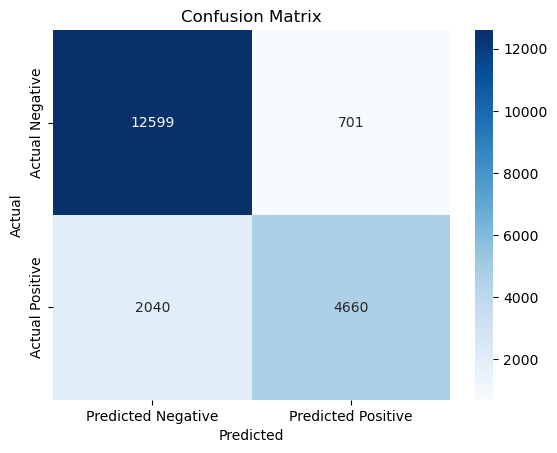

In [13]:
sns.heatmap(all_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Results Visualization

In [14]:
# printing training loss for each fold.
avg_train_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(train_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_train_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Train Loss = {}, Average Train Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Train Loss = 0.1282971460058115, Average Train Accuracy = 0.8717028539941885
Fold 2: Average Train Loss = 0.13564072892960513, Average Train Accuracy = 0.8643592710703949
Fold 3: Average Train Loss = 0.15100553816810883, Average Train Accuracy = 0.8489944618318912
Fold 4: Average Train Loss = 0.12935103727512098, Average Train Accuracy = 0.870648962724879
Fold 5: Average Train Loss = 0.16535105562686206, Average Train Accuracy = 0.834648944373138


In [15]:
# printing validation loss for each fold.
avg_val_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(val_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_val_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Validation Loss = {}, Average Validation Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Validation Loss = 0.5160648603333509, Average Validation Accuracy = 0.48393513966664914
Fold 2: Average Validation Loss = 0.44653070812871903, Average Validation Accuracy = 0.5534692918712809
Fold 3: Average Validation Loss = 0.26790207615607575, Average Validation Accuracy = 0.7320979238439242
Fold 4: Average Validation Loss = 0.29447104304185234, Average Validation Accuracy = 0.7055289569581477
Fold 5: Average Validation Loss = 0.3622339574571673, Average Validation Accuracy = 0.6377660425428326


In [16]:
# Printing test set accuracy for each fold.
for value in test_acc_per_fold:
    print(value)

84.075
82.75
92.2
86.825
85.625


In [17]:
# Average accuracy
np.mean(test_acc_per_fold)

86.29499999999999

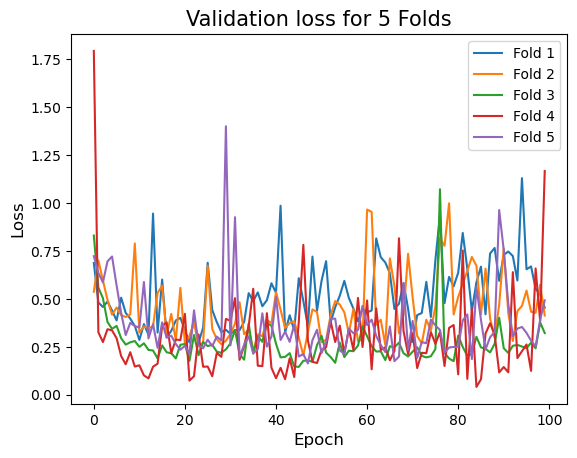

In [18]:
n_folds = len(val_loss_per_fold)
n_epochs = len(val_loss_per_fold[0])

# plot each fold's accuracy as a line plot with a different color
for i in range(n_folds):
    plt.plot(range(n_epochs), val_loss_per_fold[i], label=f"Fold {i+1}")

# set plot title, axis labels, and legend
plt.title("Validation loss for 5 Folds", fontsize = 15)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()

plt.show()

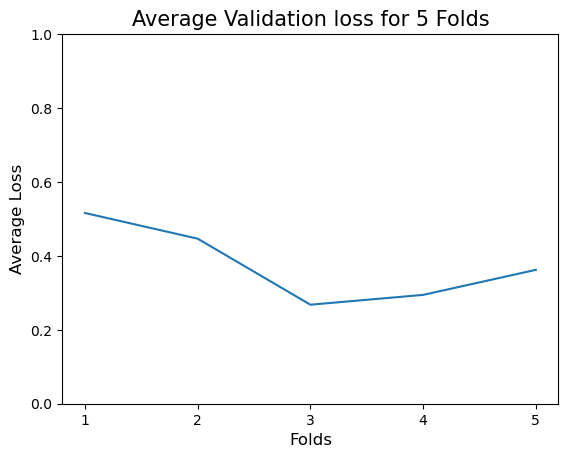

In [19]:
# Plotting the data
plt.plot(range(1, len(avg_val_loss_per_fold) + 1), avg_val_loss_per_fold)
plt.xticks(range(1, len(avg_val_loss_per_fold) + 1))

# Set y-axis range
plt.ylim(0, 1.0)

# Set plot title, axis labels, and legend
plt.title("Average Validation loss for 5 Folds", fontsize=15)
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)

# Display the plot
plt.show()

In [20]:
final_model_save_path = r'C:\Users\anikd\Desktop\NC_vs_PAE\final_model_aug_all_copy2.pth'
torch.save(modified_model.state_dict(), final_model_save_path)